# Optimization

Hello, and welcome to our tutorial on optimization. Here, we will explore the four different optimizers which already have `Tequila` interfaces: a native GD optimizer, alongside interfaces for `SciPy`, `GPyOpt`, and `Phoenics`.

In [1]:
### start at the start: import statements!
import tequila as tq
import numpy as np
import matplotlib.pyplot as plt

## Overview

**How to optimize an `Objective`:**

 In `tequila`, optimizers are accessed in several ways. They may be instantiated as objects directly, which can then be called; they are also accessible through `tq.minimize`. Either of these methods have an obligatory argument: an `Objective`. `tq.minimize` also requires you supply a `method`, which must be a string; the call methods of the GD, `SciPy`, and `GPyOpt` optimizers accept this key as well.
 
As keywords to any optimization call, you can pass down the usual compilation kwargs for quantum simulation in `Tequila`:
* `backend`, a string indicating which quantum simulator to use
* `samples`, an int indicating how many shots of the circuit to measure (None means full wf simulation)
* `device`, (generally) a string indicating which (real or emulated) quantum computer to sample from (requires samples be specified),
* `noise`, the NoiseModel object to apply to the circuits simulated (see the tutorial on noise). 

additional keywords you might use include:
* `variables`,  a `list` of the `Variable`s you want to optimize (the default is all of them).
* `initial_values`, which gives a start point to optimization. If you supply arguments to `variables`, you also need to supply arguments to `initial_values` so that all non-optimized parameters have a value to use. The default is random initialization (not recomended) 
* `gradient`, which specifies which type of gradient will be used : analytical gradients (Default): gradient=None, numerical gradients: gradient={'method':'2-point', "stepsize":1.e-4}, custom gradient objectives: gradient={tq.Variable:tq.Objective}, module specific gradients: gradient="2-point" (to use for example `SciPy` finite difference stencils).
* `silent`, silence outputs

Some of the optimizers take more, or different, keywords from the others, so check the documentation for each one. 
In case the optimizer has some degree of verbosity (currently, they all do), you can deactivate this with `silent=True`. 

The following optimization methods are available on your system in `Tequila`:

In [2]:
tq.optimizers.show_available_optimizers()

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
spsa                 | gd
Supported optimizer modules:  ['scipy', 'phoenics', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', 'gd']


We will use two different `Objective`s for optimization in this tutorial. The first of these is a two qubit expectation value with the tractable but non trivial hamiltonian $[Y(0)+Qm(0)]\otimes X(1)$, where $Qm=\frac{1}{2} (I - Z)$, the projector onto the |1> state. 

In [3]:
### optimizing the circuit in terms of pi makes the result of the optimization easier to interpret.

a = tq.Variable(name="a")*tq.numpy.pi
b = tq.Variable(name="b")*tq.numpy.pi
c = tq.Variable(name="c")*tq.numpy.pi
d = tq.Variable(name='d')*tq.numpy.pi

U1 = tq.gates.H(target=[0])
U1 += tq.gates.H(target=1)
U1 += tq.gates.Ry(target=0, angle=a)
U1 += tq.gates.Rz(target=1, angle=b)
U1 += tq.gates.Z(target=1,control=0)
U1 += tq.gates.Rx(target=0, angle=c)
U1 += tq.gates.Rx(target=1,angle=d)
U1 += tq.gates.Z(target=1,control=0)


### once we have a circuit, we pick a hamiltonian to optimize over
H1=(tq.paulis.Y(0)+tq.paulis.Qm(0))*tq.paulis.X(1)
O1=tq.ExpectationValue(U=U1,H=H1)

### we use the .draw function to pretty-print circuits via backend printers.
print('We will optimize the following objective: \n')
tq.draw(O1,backend='qiskit')

We will optimize the following objective: 

Objective with 1 unique expectation values
total measurements = 3
variables          = [a, b, c, d]
types              = not compiled

Expectation Value 0:
total measurements = 3
variables          = 4
circuit            = 7100748135979003656_0.png


Our second `Objective`, O2, will measure a 3-qubit circuit with respect to the Hamiltonian $Y(0)\otimes X(1) \otimes Y(2)$

In [4]:
### this time, don't scale by pi

H2 = tq.paulis.Y(0)*tq.paulis.X(1)*tq.paulis.Y(2)
U2 = tq.gates.Ry(tq.numpy.pi/2,0) +tq.gates.Ry(tq.numpy.pi/3,1)+tq.gates.Ry(tq.numpy.pi/4,2)
U2 += tq.gates.Rz('a',0)+tq.gates.Rz('b',1)
U2 += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
U2 += tq.gates.Ry('c',1) +tq.gates.Rx('d',2)
U2 += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
O2 = tq.ExpectationValue(H=H2, U=U2)

print('We will optimize the following objective: \n')
tq.draw(O2, backend="qiskit")

We will optimize the following objective: 

Objective with 1 unique expectation values
total measurements = 1
variables          = [a, b, c, d]
types              = not compiled

Expectation Value 0:
total measurements = 1
variables          = 4
circuit            = 7100748135979003656_0.png


## Local Optimizers

We will begin this tutorial by focusing on local optimizers. By local optimization, we mean the any optimization schema where the suggested parameters at step t are always a transformation of the parameters suggested at step t-1. This includes a large number of the standard optimization techniques in use today, like gradient descent.     `Tequila` comes with two local optimizers: a native gradient descent optimizer, implementing a number of the most popular gradient descent algorithms used in classical machine learning, as well as a plugin for the `SciPy` package (which is installed alongside `Tequila`), which allows the use of a number of gradient-free, gradient-based, and hessian-based optimization methods.

### The GD Optimizer
we will start this tutorial by looking at the GD optimizer. Here is an overview over the available optimization methods.


In [5]:
tq.show_available_optimizers(module="gd")

available methods for optimizer module gd
method               | optimizer module
--------------------------
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
spsa                 | gd


As one sees, a variety of methods are available for optimization. Here, 'sgd' refers to the standard gradient descent algorithm, without momentum. like all tequila optimizers, the GD optimizer has a minimize function and most of the arguments are the same. However, there is one important difference: the GD optimizer takes a learning rate, lr. This parameter mediates step size in all of the GD optimizer methods; it is a positive float which scales the step in the direction of the gradient. 


We will now optimize O1, our two-qubit expectation value, choosing starting angles equivalent to $\frac{1}{4}\pi$ for all four variables, and optimizing via the ['Adam'](https://towardsdatascience.com/_adam-latest-trends-in-deep-learning-optimization-6be9a291375c) method.

In [6]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.1

### For even more fun, try using sampling with the samples keyword, 
### or pick your favorite backend with the 'backend' keyword!

adam_result=tq.minimize(objective=O1,lr=lr,
              method='adam',
              maxiter=80,
              initial_values=init,
              silent=True)

The plots below show the trajectory of both the value of the objective and the values of the angles as a function of time.

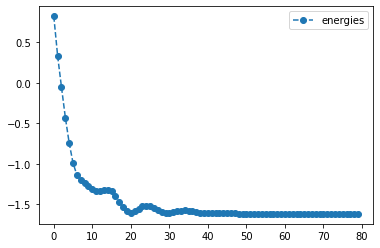

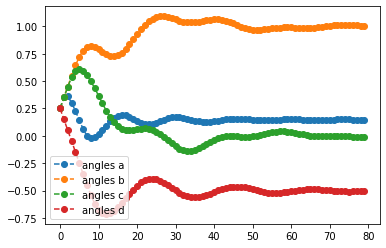

best energy:  -1.6179942172570136
optimal angles:  a : 0.14749682605178346
b : 1.0037044962376886
c : -0.0020942074899867142
d : -0.498209057390019



In [7]:
adam_result.history.plot('energies')
adam_result.history.plot('angles')
print('best energy: ',adam_result.energy)
print('optimal angles: ',adam_result.angles)

**We see that, minus a few hiccups, all the angles converge to optimimum values.**

**Let's repeat what we did above, but with a few of the other methods! Here's RMSprop:**

RMSprop optimization results:


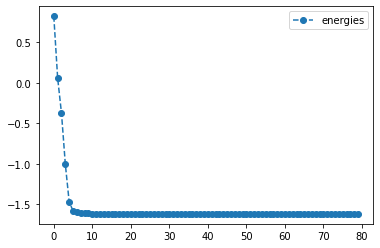

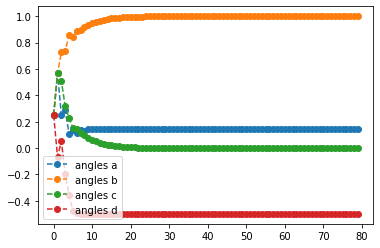

best energy:  -1.6180339887498905
optimal angles:  a : 0.14758363531643576
b : 1.0000000183809166
c : -1.625339216876925e-08
d : -0.5000000021961905



In [8]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.01
rms_result=tq.minimize(objective=O1,lr=lr,
              method='rmsprop',
              maxiter=80,
              initial_values=init,
              silent=True)
print('RMSprop optimization results:')
rms_result.history.plot('energies')
rms_result.history.plot('angles')
print('best energy: ',rms_result.energy)
print('optimal angles: ',rms_result.angles)

**... And here's Momentum:**

momentum optimization results:


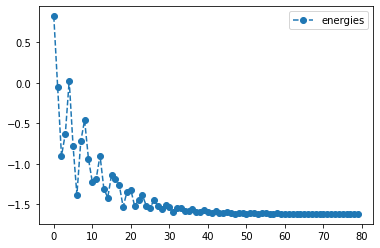

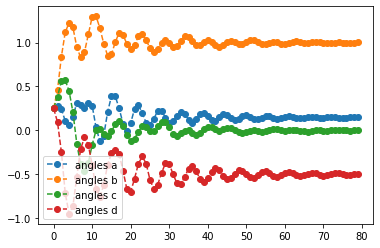

best energy:  -1.6178164176706864
optimal angles:  a : 0.153130292696303
b : 0.9975386964199592
c : -0.0008949959645234715
d : -0.5018114831041253



In [9]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.1
mom_result=tq.minimize(objective=O1,lr=lr,
              method='momentum',
              maxiter=80,
              initial_values=init,
              silent=True)

print('momentum optimization results:')
mom_result.history.plot('energies')
mom_result.history.plot('angles')
print('best energy: ',mom_result.energy)
print('optimal angles: ',mom_result.angles)

Note that when using the [RMSprop](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) method, we reduced the learning rate from 0.1 to 0.01. Different methods may be more or less sensitive to choices of initial learning rate. Try going back to the previous examples, and choosing different learning rates, or different initial parameters, to gain a feel for how sensitive different methods are.

**Accelerated gradient descent to achieve numerical accuracy:**

One issue with gradient descent is that they are slow when it comes to converging to machine precision. Indeed, as one approaches an optimum, the gradient goes to zero, which means that each successive step is smaller and smaller, and convergence slows down. This is not really a problem in machine learning, where convergence to many digits is not needed, but it is an issue in chemistry.

The standard method used to converge quantum chemical calculations is an accelerated form of gradient descent alternatively called Direct Inversion of the Iterative Subspace (DIIS) or Pulay mixing (for its inventor Peter Pulay). Basically, DIIS extrapolates from the error on past function evaluation to where the error is zero using a subspace approach. It is closely related to other subpsace and Krylov methods, such as GMRES.

DIIS works best once we are pretty close to our solution. In this case, we start from a significantly better initial guess, and try to achieve a tolerance of 1e-9 with just standard gradient descent,


In [10]:
init={'a':0.18,'b':0.8,'c':-0.1,'d':-0.4}
lr=0.1
no_diis_result=tq.minimize(objective=O1,lr=lr,
              method='sgd',
              tol=1e-10,
              maxiter=80,
              initial_values=init,
              silent=False)

Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 8 expectationvalues
gradient instr  : None
active variables : 4
iter.        <O>          Δ<O>      max(d<O>)   rms(d<O>)
  1       -1.61467625   -2.87e-01   1.603e-01   1.169e-01    
  2       -1.61755894   -2.88e-03   3.376e-02   2.077e-02    
  3       -1.61770417   -1.45e-04   2.436e-02   1.566e-02    
  4       -1.61779488   -9.07e-05   2.099e-02   1.332e-02    
  5       -1.61786059   -6.57e-05   1.788e-02   1.135e-02    
  6       -1.61790828   -4.77e-05   1.523e-02   9.665e-03    
  7       -1.61794287   -3.46e-05   1.297e-02   8.230e-03    
  8       -1.61796795   -2.51e-05   1.104e-02   7.008e-03    
  9       -1.61798613   -1.82e-05   9.403e-03   5.966e-03    
 10       -1.61799931   -1.32e-05   8.006e-03   5.079e-03    
 11       -1.61800

We run out of iterations. Looking at the printout (obtained with `silent=False`), we see that convergence is achieved after 46 steps. We note that specifically convergence slows down significantly after 5 steps, as the gradients (and thus step sizes) become smaller the closer we get to the minima. This is the problem DIIS solves.

Let's try again with acceleration.

In [11]:
diis_result=tq.minimize(objective=O1,lr=lr,
              method='sgd',
              diis={'tol':1e-1},
              tol=1e-10,
              maxiter=80,
              initial_values=init,
              silent=False)

Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 8 expectationvalues
gradient instr  : None
active variables : 4
iter.        <O>          Δ<O>      max(d<O>)   rms(d<O>)
  1       -1.61467625   -2.87e-01   1.603e-01   1.169e-01    
  2       -1.61755894   -2.88e-03   3.376e-02   2.077e-02    
  3       -1.61770417   -1.45e-04   2.436e-02   1.566e-02    DIIS
  4       -1.61783934   -1.35e-04   1.908e-02   1.203e-02    DIIS
  5       -1.61803383   -1.94e-04   1.855e-03   9.289e-04    DIIS
  6       -1.61802839   +5.45e-06   1.098e-02   5.504e-03    DIIS
  7       -1.61803399   -5.60e-06   7.242e-05   3.631e-05    DIIS
  8       -1.61803399   -2.04e-10   2.974e-05   1.492e-05    DIIS
delta f smaller than tolerance 1e-10. Stopping optimization.


Convergence is obtained in just 8 steps. We can see here that DIIS kicks in at step 3, that is, when max(gradient) is below 1e-1 (the `tol=` argument in the DIIS dictionary) and we have accumulated at least 3 vectors. Once DIIS starts, convergence is very rapid, with a four orders of magnitude drop in the error in only three steps.

We can see this most clearly in a log plot of the error,

In [15]:
print('SGD + DIIS optimization results:')
Emin = diis_result.history.energies[-1]
plt.semilogy(no_diis_result.history.energies[:-1] - Emin)
plt.semilogy(diis_result.history.energies[:-1] - Emin)
plt.ylabel('Error on energy')
plt.legend(['without DIIS', 'with DIIS'])

SGD + DIIS optimization results:


TypeError: unsupported operand type(s) for -: 'list' and 'float'

We clearly see here that when DIIS kicks in, convergence rapidly accelerates. In comparison, the convergence rate of standard gradient descent actually gets slower the closer we are to a solution. However, it should be noted that DIIS is not entirely stable and only really works close to an optima. Furthermore, the implementation here is somewhat experimental. Use at your own risk!

**The GD optimizer, with the Quantum Natural Gradient:**

The Quantum Natural Gradient, or QNG, is a novel method of calculating gradients for quantum systems, inspired by the natural gradient sometimes employed in classical machine learning. The usual gradient we employ is with respect to a euclidean manifold, but this is not the only geometry -- nor even, the optimal geometry -- of quantum space. The QNG is, in essence, a method of taking gradients with respect to (an approximation to) the Fubini-Study metric. For information on how (and why) the QNG is used, see [Stokes et.al](https://arxiv.org/abs/1909.02108). 

Using the qng in Tequila is as simple as passing in the keyword gradient='qng' to optimizers which support it, such as the GD optimizer.  We will use it to optimize O2, our 3 qubit `Objective`, and then compare the results to optimizing the same circuit with the regular gradient.

In [16]:
### the keyword stop_count, below, stops optimization if no improvement occurs after 50 epochs.
### let's use a random initial starting point:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}

lr=0.01
qng_result = tq.minimize(objective=O2,
                     gradient='qng',
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=init, silent=True)

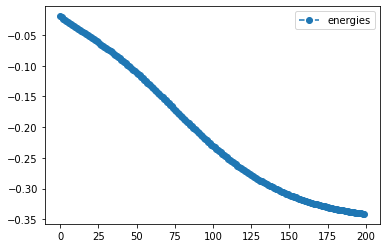

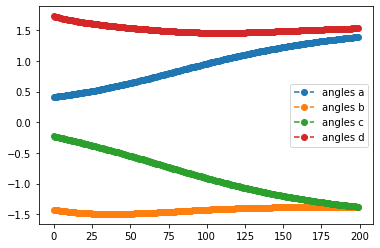

best energy with qng:  -0.34132253215370895
optimal angles with qng:  a : 1.3897329376581569
b : -1.3809534723985462
c : -1.3794375781701278
d : 1.5320200449107626



In [17]:
qng_result.history.plot('energies')
qng_result.history.plot('angles')
print('best energy with qng: ',qng_result.energy)
print('optimal angles with qng: ',qng_result.angles)

To gain appreciation for why one might use the QNG, let's optimize the same circuit with the same learning rate and the same method, but without QNG.

plotting what happens without QNG


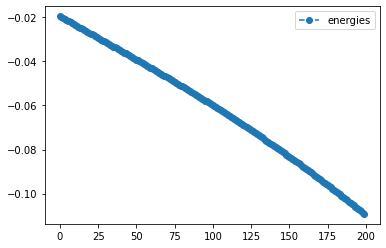

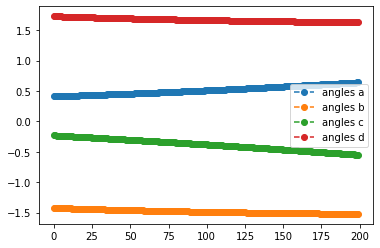

best energy without qng:  -0.10921550575273653
optimal angles without qng:  a : 0.6409947697761912
b : -1.5230540932287167
c : -0.5504214318083003
d : 1.62974522770631



In [18]:
lr=0.01
sgd_noqng_result = tq.minimize(objective=O2,
                     gradient=None,
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=init, silent=True)
print('plotting what happens without QNG')
sgd_noqng_result.history.plot('energies')
sgd_noqng_result.history.plot('angles')
print('best energy without qng: ',sgd_noqng_result.energy)
print('optimal angles without qng: ',sgd_noqng_result.angles)

Though the starting point was random you will most likely see that the QNG run achieved a greater degree of improvement -- it will not perform worse --, and that the trajectories followed by angles there were different from those followed by angles in the sgd-only optimization. Feel free to play around with other methods, learning rates, or circuits in the space below!


In [13]:
### Use this space to optimize your own circuits!

### The SciPy Optimizer

`SciPy` is one of the most popular optimization packages in `Python`. It offers a wide variety of optimization strategies. We will not cover them here; for a full exploration of all the `SciPy` methods, see [their docs](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html). Here, we will exhibit a few of the more powerful options available. Most `SciPy` keywords like `method_options` can just be passed to `minimize` directly in the same way as when using `SciPy` directly.  

In [14]:
tq.show_available_optimizers(module="scipy")

available methods for optimizer module scipy
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy


We will try three different optimizers: `COBYLA`, which is gradient-free, `L-BFGS-B`, which employs gradients, and `NEWTON-CG`, which employs the Hessian.

In [15]:
print('As a reminder: we will optimize:')
tq.draw(O1, backend="qiskit")

As a reminder: we will optimize:
Objective with 1 unique expectation values
variables = [a, b, c, d]
types     = not compiled

Expectation Value 0
Hamiltonian :  (+1.0000Y(0)X(1)+0.5000X(1)-0.5000Z(0)X(1),)
variables :  [a, b, c, d]
circuit:

     ┌───┐┌───────────────┐   ┌───────────────┐   
q_0: ┤ H ├┤ RY(f((a,))_0) ├─■─┤ RX(f((c,))_2) ├─■─
     ├───┤├───────────────┤ │ ├───────────────┤ │ 
q_1: ┤ H ├┤ RZ(f((b,))_1) ├─■─┤ RX(f((d,))_3) ├─■─
     └───┘└───────────────┘   └───────────────┘   
c_0: ═════════════════════════════════════════════
                                                  
c_1: ═════════════════════════════════════════════
                                                  


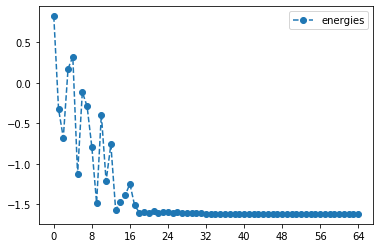

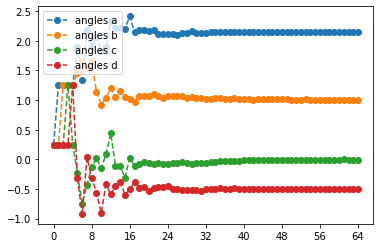

best energy with cobyla:  -1.6180095801270247
optimal angles with cobyla:  a : 2.1466459827493174
b : 1.002273376125911
c : -0.003983388162904869
d : -0.5006752029196884



In [16]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}

cobyla_result = tq.minimize(objective=O1,
                            method="cobyla", 
                            initial_values=init, 
                            tol=1.e-3, method_options={"gtol":1.e-3},
                            silent=True)

cobyla_result.history.plot('energies')
cobyla_result.history.plot('angles')
print('best energy with cobyla: ',cobyla_result.energy)
print('optimal angles with cobyla: ',cobyla_result.angles)

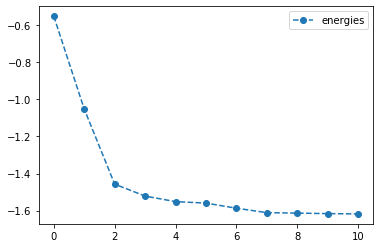

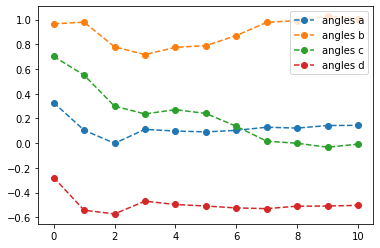

best energy with L-BFGS-B:  -1.6178070201838934
optimal angles with L-BFGS-B:  a : 0.14354383870194684
b : 1.0061131726451131
c : -0.00825692744088291
d : -0.5036909480382052



In [17]:
lb_result = tq.minimize(objective=O1,
                            method="l-bfgs-b", 
                            initial_values=init, 
                            tol=1.e-3, method_options={"gtol":1.e-3},
                            silent=True)

lb_result.history.plot('energies')
lb_result.history.plot('angles')
print('best energy with L-BFGS-B: ',lb_result.energy)
print('optimal angles with L-BFGS-B: ',lb_result.angles)

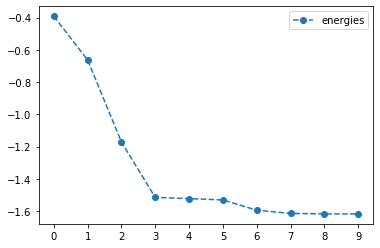

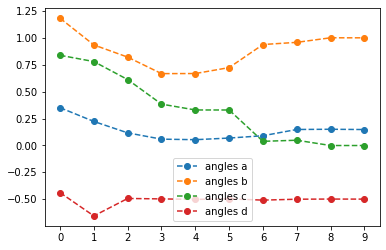

best energy with NEWTON-CG:  -1.6180323934132854
optimal angles with NEWTON-CG:  a : 0.14753463639545006
b : 1.0008716211744726
c : -0.0011067836511529652
d : -0.4998455957582174



In [18]:
newton_result = tq.minimize(objective=O1,
                            method="newton-cg", 
                            initial_values=init, 
                            tol=1.e-3, method_options={"gtol":1.e-3},
                            silent=True)

newton_result.history.plot('energies')
newton_result.history.plot('angles')
print('best energy with NEWTON-CG: ',newton_result.energy)
print('optimal angles with NEWTON-CG: ',newton_result.angles)

All three of the methods converged to the same minimum, but not necessarily to the same angles; the gradient and hessian based methods converged to approximately the same angles in similar time. 

**Scipy Extras: numerical gradients and Hessians**
Scipy allows for the use of numerical gradients. To use them, pass down keywords to the `gradient` argument, like `'2-point'`. When using the numerical gradients of `SciPy` it is often crucial to determine a feasible stepsize for the procedure. This can be done with the `method_options` entry `finite_diff_rel_step` (for `SciPy` version 1.5 or higher) or `eps` (for `SciPy` version < 1.5).

Here is one example. **Please check your SciPy version!**

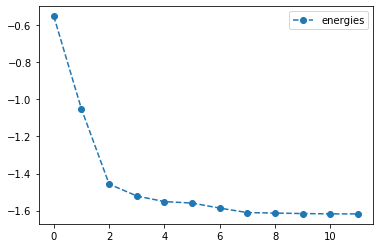

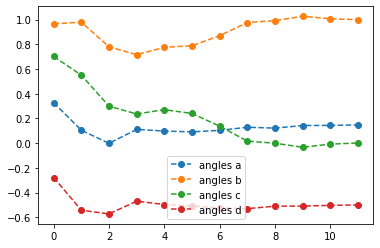

best energy with L-BFGS-B:  -1.6180322764615407
optimal angles with L-BFGS-B:  a : 0.14737921020398723
b : 0.9991028633007109
c : 0.0010812477825766602
d : -0.5000405396241386



In [19]:
lb_result = tq.minimize(objective=O1,
                            method="l-bfgs-b", 
                            initial_values=init,
                            gradient="2-point",
                            tol=1.e-3, method_options={"gtol":1.e-3, "finite_diff_rel_step":1.e-4}, # eps for scipy version < 1.5
                            silent=True)

lb_result.history.plot('energies')
lb_result.history.plot('angles')
print('best energy with L-BFGS-B: ',lb_result.energy)
print('optimal angles with L-BFGS-B: ',lb_result.angles)

**Scipy Extras: the QNG in SciPy**
Scipy is also configured to use the qng, just as the gd optimizer is. All one needs to do is set `gradient=qng`. Let's See how QNG interacts with the `BFGS` optimizer. We will use 02, our 3-qubit expectationvalue, that we used previously.

plotting what happens with QNG


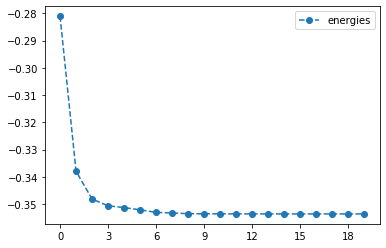

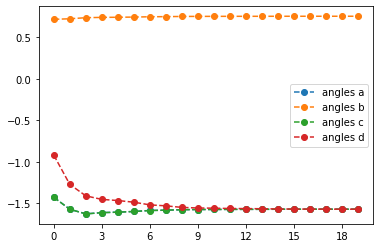

best energy with qng:  -0.3535533676156721
optimal angles with qng:  a : -1.570884542409681
b : 0.754829536265003
c : -1.5708867115312135
d : -1.5704585913166933



In [20]:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}
lr=0.01
bfgs_qng_result = tq.minimize(objective=O2,
                     gradient='qng',
                     method='bfgs', maxiter=200,lr=lr,
                     initial_values=init, silent=True)
print('plotting what happens with QNG')
bfgs_qng_result.history.plot('energies')
bfgs_qng_result.history.plot('angles')
print('best energy with qng: ',bfgs_qng_result.energy)
print('optimal angles with qng: ',bfgs_qng_result.angles)

plotting what happens without QNG


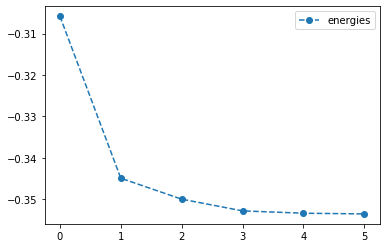

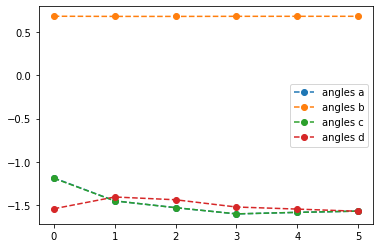

best energy without qng:  -0.35355296837705463
optimal angles without qng:  a : -1.5699318047491537
b : 0.6835176416172444
c : -1.5699495726072827
d : -1.5717565421037312



In [21]:
bfgs_noqng_result = tq.minimize(objective=O2,
                     gradient=None,
                     method='bfgs', maxiter=200,lr=lr,
                     initial_values=init, silent=True)
print('plotting what happens without QNG')
bfgs_noqng_result.history.plot('energies')
bfgs_noqng_result.history.plot('angles')
print('best energy without qng: ',bfgs_noqng_result.energy)
print('optimal angles without qng: ',bfgs_noqng_result.angles)

## Numerical and Customized Gradients

By default `tequila` compiles analytical gradients of the objectives using `jax`, internal recompilation and the parameter shift rule. The default is not setting the `gradient` keyword or setting it to `None`. The keyword can also be set to a dictionary (keys are the variables, values are the `tequila` objectives which are assumed to evaluate to the corresponding gradients of the objective).  
For example `gradient=tq.grad(objective)` will results have the same results as `gradient=None` or simply not setting it.

`tequila` offers its own way of compiling numerical gradients which can then be used troughout all gradient based optimizers. It can be activated by setting `gradient` to a dictionary holding the finite difference stencil as `method` as well as the `stepsize`.   

Numerical gradients of that type come with the cost of 2*`len(variables)` and can lead to significantly cheaper gradients, especially if many expectation values are involved in the objective and/or if heavy recompilation of parametrized gates is necessary. 
Here is a small example using our `O2` objective, here the numerical 2-point procedure leads to 4 expectation values in the gradients (while anayltial gradients would lead to 8, set silent to False in the upper example or remove the gradient statement here).

In [32]:
lr=0.01
num_result = tq.minimize(objective=O2,
                     gradient={"method":"2-point", "stepsize":1.e-4},
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=0.1, silent=False)

Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 4 expectationvalues
gradient instr  : {'method': '2-point', 'stepsize': 0.0001}
active variables : 4
Iteration: 1 , Energy: -0.60003241, angles: {a: 0.09936269222059471, b: 0.09939775441865076, c: 0.09936269222059471, d: 0.09936269222060581}
Iteration: 2 , Energy: -0.60018803, angles: {a: 0.09872953938259146, b: 0.09879900936485822, c: 0.09872953938259146, d: 0.09872953938264697}
Iteration: 3 , Energy: -0.60034166, angles: {a: 0.0981005608850504, b: 0.09820379122594805, c: 0.09810056088502819, d: 0.0981005608850948}
Iteration: 4 , Energy: -0.60049334, angles: {a: 0.09747568193347869, b: 0.09761199308737636, c: 0.09747568193347869, d: 0.09747568193355641}
Iteration: 5 , Energy: -0.60064311, angles: {a: 0.09685487540521667, b: 0.09702364170889313, c: 0

Iteration: 65 , Energy: -0.60688310, angles: {a: 0.0661279383438961, b: 0.06738724349811812, c: 0.06612793834369626, d: 0.06612793834398492}
Iteration: 66 , Energy: -0.60695193, angles: {a: 0.06571055413201457, b: 0.06697758574548676, c: 0.06571055413177032, d: 0.06571055413208118}
Iteration: 67 , Energy: -0.60701988, angles: {a: 0.06529586361294629, b: 0.0665703810021955, c: 0.06529586361269094, d: 0.0652958636130129}
Iteration: 68 , Energy: -0.60708697, angles: {a: 0.06488387954099997, b: 0.06616561524409584, c: 0.06488387954073352, d: 0.06488387954105548}
Iteration: 69 , Energy: -0.60715322, angles: {a: 0.06447452255616817, b: 0.0657633045205274, c: 0.06447452255590172, d: 0.06447452255623479}
Iteration: 70 , Energy: -0.60721863, angles: {a: 0.06406780590619823, b: 0.06536337486069402, c: 0.06406780590594288, d: 0.06406780590628705}
Iteration: 71 , Energy: -0.60728321, angles: {a: 0.06366371207211499, b: 0.06496584259177976, c: 0.06366371207190405, d: 0.06366371207221491}
Iteration:

Iteration: 129 , Energy: -0.60991784, angles: {a: 0.044171709961215916, b: 0.04557320074181073, c: 0.04417170996097167, d: 0.04417170996118261}
Iteration: 130 , Energy: -0.60994842, angles: {a: 0.04389521821988032, b: 0.045295030473535475, c: 0.04389521821962497, d: 0.04389521821982481}
Iteration: 131 , Energy: -0.60997861, angles: {a: 0.04362048886594741, b: 0.04501854684014753, c: 0.04362048886570316, d: 0.043620488865903}
Iteration: 132 , Energy: -0.61000842, angles: {a: 0.04334751034099629, b: 0.044743739818764366, c: 0.04334751034074094, d: 0.04334751034092968}
Iteration: 133 , Energy: -0.61003786, angles: {a: 0.043076281278386835, b: 0.04447059944927548, c: 0.04307628127810928, d: 0.04307628127830912}
Iteration: 134 , Energy: -0.61006693, angles: {a: 0.042806769993153276, b: 0.04419912593658362, c: 0.04280676999287572, d: 0.04280676999308666}
Iteration: 135 , Energy: -0.61009563, angles: {a: 0.042538975318639954, b: 0.04392929919156954, c: 0.0425389753183624, d: 0.042538975318584

Iteration: 187 , Energy: -0.61118373, angles: {a: 0.030722854915010617, b: 0.03194090640388217, c: 0.030722854914744163, d: 0.03072285491487739}
Iteration: 188 , Energy: -0.61119847, angles: {a: 0.03053168534846709, b: 0.031745615778777575, c: 0.030531685348222842, d: 0.030531685348344967}
Iteration: 189 , Energy: -0.61121301, angles: {a: 0.03034172219574796, b: 0.03155151537334025, c: 0.030341722195470405, d: 0.030341722195603632}
Iteration: 190 , Energy: -0.61122738, angles: {a: 0.030152957642504058, b: 0.031358605190812044, c: 0.030152957642204298, d: 0.030152957642348627}
Iteration: 191 , Energy: -0.61124157, angles: {a: 0.029965383958363484, b: 0.031166870815446585, c: 0.02996538395804152, d: 0.02996538395819695}
Iteration: 192 , Energy: -0.61125558, angles: {a: 0.029778989963113928, b: 0.03097630159609724, c: 0.029778989962847474, d: 0.029778989962958496}
Iteration: 193 , Energy: -0.61126941, angles: {a: 0.029593774982561355, b: 0.0307868940690236, c: 0.029593774982306004, d: 0.0

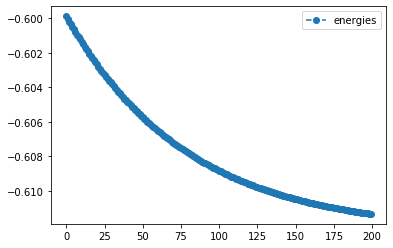

In [33]:
num_result.history.plot('energies')

`tequila` currently offers `2-point` as well as `2-point-forward` and `2-point-backward` stencils as `method`.
The method can also be set to a python function performing the task. Here is an example which implements the same as `2-point`. The function can be replaced by any function with the same signature.

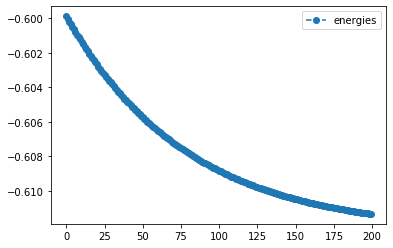

In [39]:
import copy
def my_finite_difference_stencil(obj, var_vals, key, step, *args, **kwargs):
        """
        calculate objective gradient by symmetric shifts about a point.
        Parameters
        ----------
        obj: Objective:
            objective to call.
        var_vals:
            variables to feed to the objective.
        key:
            which variable to shift, i.e, which variable's gradient is being called.
        step:
            the size of the shift; a small float.
        args
        kwargs

        Returns
        -------
        float:
            the approximated gradient of obj w.r.t variable key at point var_vals[key] as a float.

        """
        left = copy.deepcopy(var_vals)
        left[key] += step / 2
        right = copy.deepcopy(var_vals)
        right[key] -= step / 2
        return 1.0 / step * (obj(left, *args, **kwargs) - obj(right, *args, **kwargs))

num_result = tq.minimize(objective=O2,
                     gradient={"method":my_finite_difference_stencil, "stepsize":1.e-4},
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=0.1, silent=True)
num_result.history.plot('energies')

The `gradient` keyword can also be replaced by a dictionary of `tequila` objectives which evaluate to gradients approximations of it.

## SPSA optimization


[SPSA optimization](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.19.4562&rep=rep1&type=pdf) is a stochastic method of optimization, often used when there is noise. One of its strengths is that the gradient approximation used only requires two measurements of the objective function, regardless of the dimension of the optimization problem. It works as the rest of the GD optimizers and with the added parameter `c`: a float used for calculating the gradient. Both, lr and c, can be given as a list of floats; when acting as lists the k-element of the list will be used for the k iteration of the algorithm. Following the same line as the gd examples:

momentum optimization results:


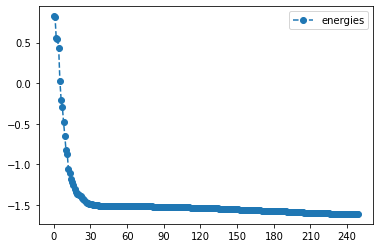

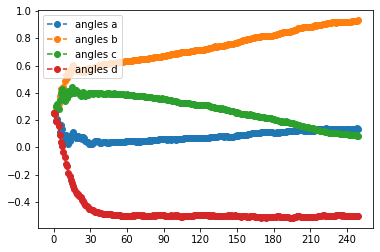

best energy:  -1.6096280731087007
optimal angles:  a : 0.1367610127577853
b : 0.9325127323425582
c : 0.08219319909648509
d : -0.5051862518021747



In [24]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.01
c=0.01
mom_result=tq.minimize(objective=O1,lr=lr,
              method='spsa',
              c=c,
              maxiter=250,
              initial_values=init,
              silent=True)

print('momentum optimization results:')
mom_result.history.plot('energies')
mom_result.history.plot('angles')
print('best energy: ',mom_result.energy)
print('optimal angles: ',mom_result.angles)

## Bayesian optimization


[Bayesian optimization](https://arxiv.org/abs/1807.02811) is a method of global optimization, often used to tune hyperparameters in classical learning. It has also seen use in the optimization of [quantum circuits](https://arxiv.org/pdf/1812.08862.pdf). Tequila currently supports 2 different bayesian optimization algorithms: [Phoenics](https://github.com/aspuru-guzik-group/phoenics) and [GPyOpt](https://github.com/SheffieldML/GPyOpt), optimizers originally developed for optimizing expensive experimental procedures in chemistry. Click the links to get to the respective github pages, and download the optimizers before continuing this tutorial.

### GPyOpt

GPyOpt can be used like any of our other optimizers. Like the GD and SciPy optimizers, it also takes a 'method' keyword. 3 methods are supported: `'gpyopt-lbfgs'`,`'gpyopt-DIRECT'`, and `'gpyopt-CMA'`. See the `GPyOpt` github for more info.

In [25]:
print('As a reminder, we will optimize')
tq.draw(O1,backend='qiskit')

As a reminder, we will optimize
Objective with 1 unique expectation values
variables = [a, b, c, d]
types     = not compiled

Expectation Value 0
Hamiltonian :  (+1.0000Y(0)X(1)+0.5000X(1)-0.5000Z(0)X(1),)
variables :  [a, b, c, d]
circuit:

     ┌───┐┌───────────────┐   ┌───────────────┐   
q_0: ┤ H ├┤ RY(f((a,))_0) ├─■─┤ RX(f((c,))_2) ├─■─
     ├───┤├───────────────┤ │ ├───────────────┤ │ 
q_1: ┤ H ├┤ RZ(f((b,))_1) ├─■─┤ RX(f((d,))_3) ├─■─
     └───┘└───────────────┘   └───────────────┘   
c_0: ═════════════════════════════════════════════
                                                  
c_1: ═════════════════════════════════════════════
                                                  


Optimizer: <class 'tequila.optimizers.optimizer_gpyopt.OptimizerGPyOpt'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

method          : lbfgs
Objective       : 1 expectationvalues
num acquisition: 1, time elapsed: 0.22s
num acquisition: 2, time elapsed: 0.47s
num acquisition: 3, time elapsed: 0.73s
num acquisition: 4, time elapsed: 1.46s
num acquisition: 5, time elapsed: 1.67s
num acquisition: 6, time elapsed: 1.96s
num acquisition: 7, time elapsed: 2.39s
num acquisition: 8, time elapsed: 2.78s
num acquisition: 9, time elapsed: 3.20s
num acquisition: 10, time elapsed: 3.68s
num acquisition: 11, time elapsed: 3.83s
num acquisition: 12, time elapsed: 4.06s
num acquisition: 13, time elapsed: 4.24s
num acquisition: 14, time elapsed: 4.41s
num acquisition: 15, time elapsed: 4.59s
num acquisition: 16, time elapsed: 5.07s
num acquisition: 17, time elapsed: 5.25s
num acquisition: 18, time elapsed: 5.50s
num acquisition: 

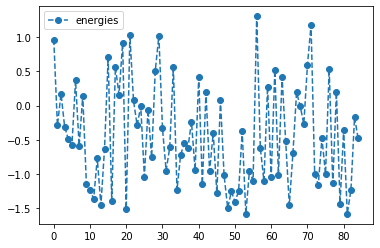

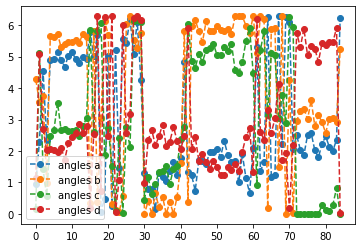

best energy:  -1.584212943157413
optimal angles:  {a: 1.870128626698086, b: 5.887193501069059, c: 5.18274634095629, d: 1.5011709655643113}


In [40]:
### let's use the gpyopt-lbfgs method.
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
### note: no lr is passed here! there are fewer tunable keywords for this optimizer.
result=tq.minimize(objective=O1,
              method='gpyopt-lbfgs',
              maxiter=80,
              initial_values=init)

print('GPyOpt optimization results:')
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

**Don't worry, the plot's not broken!**
Perhaps you are looking at the plots above in horror. But, do take note: bayesian optimization is a global, exploratory optimization method, designed to explore large portions of parameter space while still seeking out optimality. Look at the optimal energy again, and one sees that the best performance of this optimization method matched that of all the gradient descent methods. We will apply gpyopt, next, to the QNG example circuit above, and see how bayesian optimization compares to QNG and SGD.

Hey, remember me?
Objective with 1 unique expectation values
variables = [a, b, c, d]
types     = not compiled

Expectation Value 0
Hamiltonian :  (+1.0000Y(0)X(1)Y(2),)
variables :  [a, b, c, d]
circuit:

0: ───Ry(0.5π)─────Rz(0.318309886183791*pi*f((a,))_0)───@────────────────────────────────────────────@───────
                                                        │                                            │
1: ───Ry(0.333π)───Rz(0.318309886183791*pi*f((b,))_1)───X───@───Ry(0.318309886183791*pi*f((c,))_2)───X───@───
                                                            │                                            │
2: ───Ry(0.25π)─────────────────────────────────────────────X───Rx(0.318309886183791*pi*f((d,))_3)───────X───
Optimizer: <class 'tequila.optimizers.optimizer_gpyopt.OptimizerGPyOpt'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

method          : lbfgs
Objective       : 1 expectationvalues


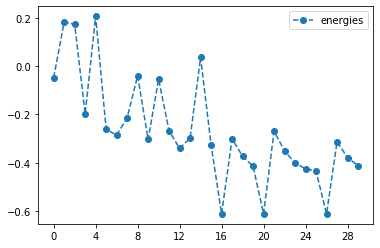

best energy:  -0.6123724356957851
optimal angles:  {a: 0.0, b: 0.0, c: 0.0, d: 6.283185307179586}


In [41]:
print('Hey, remember me?')
tq.draw(O2)
### the keyword stop_count, below, stops optimization if no improvement occurs after 50 epochs.
### let's use a random initial starting point:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}

gpy_result = tq.minimize(objective=O2,maxiter=25,method='gpyopt-lbfgs',
                     initial_values=init)

gpy_result.history.plot('energies')
print('best energy: ',gpy_result.energy)
print('optimal angles: ',gpy_result.angles)

**In a very, very small number of steps, GPyOpt is able to match the performance of SGD with the QNG.**

**There's a few extras you can access if you are well-familiar with GPyOpt.** We return as part of `result` an attribute `result.gpyopt_instance`, which is an instance of the native `GPyOpt` `BayesianOptimization` object -- the one built and run during your optimization. It has some plotting features you can use. 

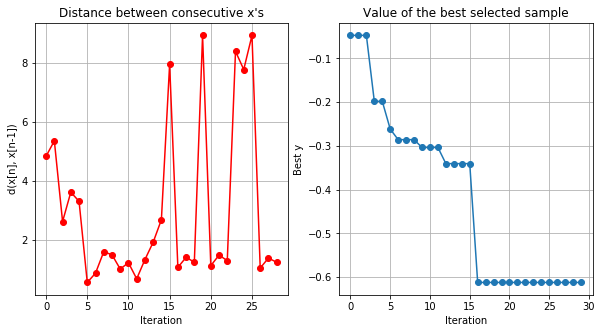

In [45]:
obj=gpy_result.gpyopt_instance
obj.plot_convergence()

If your function has 1 or 2 parameters (but no more) you can also see a plot of its acquisition function! see [here](https://www.blopig.com/blog/2019/10/a-gentle-introduction-to-the-gpyopt-module/) for more info!

You can also extract the acquisition function of the model itself, and play with it (it takes ones object, an np array, as input), using:

`acq=result.gpyopt_instance.acquisition.acquisition_function`

### Phoenics

Finally, we turn to [`Phoenics`](https://github.com/aspuru-guzik-group/phoenics). This algorithm, originally developed within the Aspuru-Guzik group, can be accessed in the usual fashion. It's performance on the two-qubit optimization circuit is shown below. Note that the number of datapoints exceeds the provided __maxiter__; __maxiter__ here controls the number of parameter __batches__ suggested by phoenics. phoenics suggests a number of parameter sets to try out, per batch, that scales with the number of parameters (in a nonlinear fashion), so you may want to set maxiter lower if you are only playing around.

With phoenics we will optimize:
Objective with 1 unique expectation values
variables = [a, b, c, d]
types     = not compiled
Phoenics config:

{'general': {'auto_desc_gen': 'False', 'batches': 5, 'boosted': 'False', 'parallel': 'False'}, 'parameters': [{'name': a, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': b, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': c, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': d, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}], 'objectives': [{'name': 'Energy', 'goal': 'minimize'}]}
phoenics has recieved
objective: 

Objective with 1 unique expectation values
variables = [a, b, c, d]
types     = not compiled
noise model : None
samples     : None
maxiter     : 5
variables   : [a, b, c, d]
passive var : {}
now lets begin
[TIME]:   0:00:00.001013   (overall)


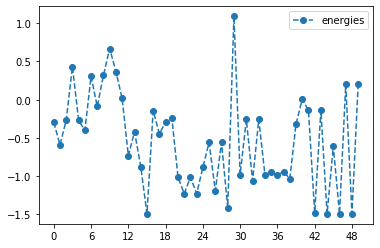

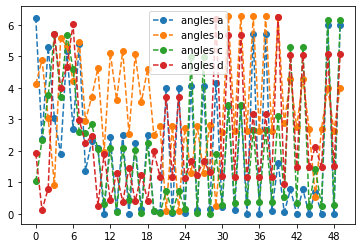

best energy:  -1.4931295501440078
optimal angles:  {a: 0.0, b: 2.70723295211792, c: 0.2528174817562103, d: 1.4755951166152954}


In [47]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
print('With phoenics we will optimize:')
print(O1)
### to see what you can pass down to phoenics, see the tequila documentation for that module.
p_result=tq.minimize(objective=O1,
            method='Phoenics',
            maxiter=5,
            initial_values=init,
            silent=False)

print('Phoenics optimization results on 2 qubit circuit:')
p_result.history.plot('energies')
p_result.history.plot('angles')
print('best energy: ',p_result.energy)
print('optimal angles: ',p_result.angles)

We also have returned to you the phoenics object. One interesting object we can extract from this is the acquisition function. You can obtain this indirectly, using resut.object.bayesian_network.kernel_contribution. This function takes a numpy array  ( a point in your parameter space) and returns 2 numbers, x and y; the acquisition function then has the value x*y. Note: this is often zero.




In [48]:
kc=p_result.phoenics_instance.bayesian_network.kernel_contribution
random_point=np.random.uniform(0,2*np.pi,4)
f,s=kc(random_point)
random_ac=f*s
print('random point ', random_point, ' has acquisition function value ',random_ac)

random point  [3.506517   3.41045123 1.98397105 5.59827826]  has acquisition function value  0.0


## This concludes our tutorial. Hope you had fun! Happy optimizing!